# Double Lorentzian method to find Signal to Noise

In [515]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [516]:
%matplotlib inline

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
from scipy import optimize
from scipy.optimize import curve_fit

#To introduce a range of 3D plots, we need to import another library
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# The following line makes the images a bit larger than default - works better on a large screen
plt.rcParams['figure.figsize'] = 10,10

import astropy
from astropy.io import fits
import os
import sys
sys.path.append(os.path.abspath(".."))
import  H_alpha as ha

## Loading images (automatic)

In [518]:
# fits file in the same folder with python notebook
home_dir = os.getcwd()+'/'
print ("The Home Directory is set to:", home_dir) # check the home directory

The Home Directory is set to: /Users/kiradavidoff/code/astrophysics/PROJECT_HALPHA/


In [519]:

Dark_files, Dark_images, Dark_names = ha.dark()
Bias_files, Bias_images, Bias_names= ha.bias()
Light_file, Light_images, Light_names= ha.lights()

## Remove readout and bias from light (automatic)

In [520]:
Bias1 = Bias_images[1]
Bias2 = Bias_images[2]

diffB = Bias2 - Bias1
dB = np.diff(Bias_images)

RDnoise = np.std(dB) / np.sqrt(100.0)

print(f"the read out noise is {RDnoise}")

the read out noise is 3274.4552163441467


In [521]:
ha.quickstats(Bias_images)

Min: 1666
Max: 7780
Mean: 1731.8538788747787
Median: 1732.0
Stdev: 11.060739853567398


In [522]:
ha.quickstats(Dark_images)

Min: 1696
Max: 65535
Mean: 1876.5062994599343
Median: 1838.0
Stdev: 235.5810478370485


In [523]:
ha.header_info(Dark_files)

Image type      =  Dark
CCD temperature =  -20.0  degrees C
Exposure time   =  300.0  seconds
Filter          =  None


In [524]:
ha.header_info(Light_file)

Image type      =  Light
CCD temperature =  -20.0  degrees C
Exposure time   =  300.0  seconds
Filter          =  None


the exposure time for Stars and Dark frame are the same

In [526]:
# subtract the mean bias from all frames
Dark_images_bs = Dark_images - np.mean(Bias_images, axis=0)

# substract the Dark frame from the Light images with bias subtracted
Light_images_correct = Light_images - np.mean(Dark_images_bs, axis=0)- np.mean(Bias_images, axis=0)


len(Light_images_correct)

15

In [527]:
# Dark uncertainty
sigma_dark = np.sqrt(np.mean(Dark_images_bs, axis=0))[522:589,0:2048] / np.sqrt(np.abs(len(Dark_images_bs)))
sigma_Bias = np.std(Bias_images,axis=0)[522:589,0:2048] / np.sqrt(len(Bias_images))
sigma_signal= np.sqrt(np.abs(Light_images_correct[0][522:589,0:2048]))

noise= np.sqrt(sigma_dark**2+sigma_Bias**2+sigma_signal**2)
noise_sqrt=np.sqrt(np.sum(noise**2,axis=0))

/var/folders/rm/q9sj039x3qqgdn5jb6y2c8k00000gn/T/ipykernel_44580/1346376083.py:2: RuntimeWarning: invalid value encountered in sqrt
  sigma_dark = np.sqrt(np.mean(Dark_images_bs, axis=0))[522:589,0:2048] / np.sqrt(np.abs(len(Dark_images_bs)))


## Removing Background on the H_alpha line

<div class="alert alert-success"> 
 <b>Plot Image to see where H_alpha is at</b>

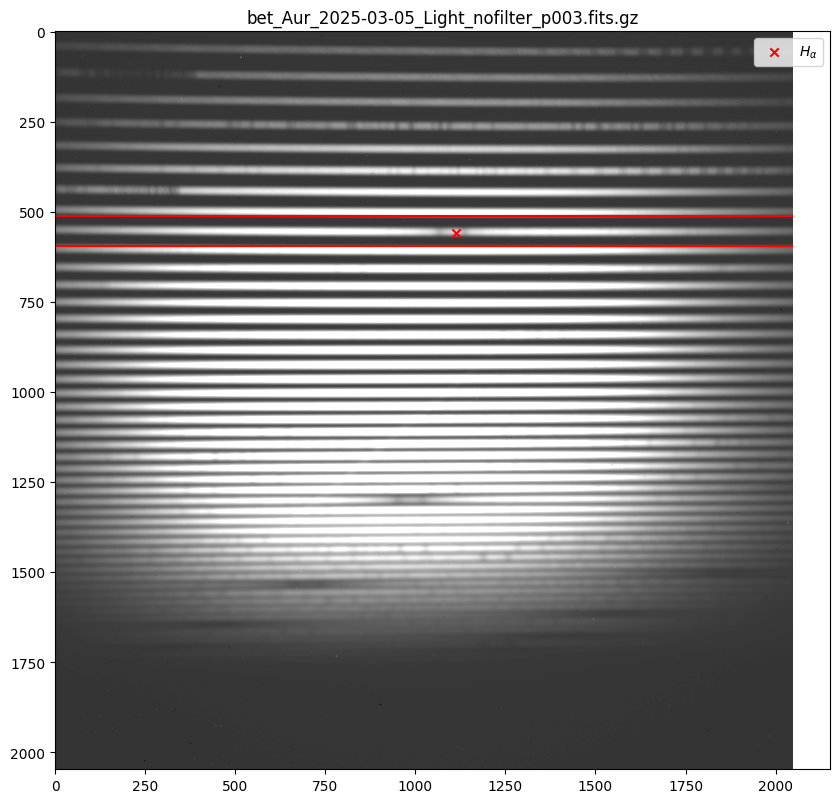

In [530]:

ha.quickplot(Light_images_correct[8], Light_names[8])
plt.scatter(1112,560, marker='x', color='red',label=r'$H_{\alpha}$')
plt.hlines(513,0,2048,'r')
plt.hlines(596,0 ,2048, 'r')
plt.legend()

<div class="alert alert-success"> 

 **Create a subset around H_alpha**

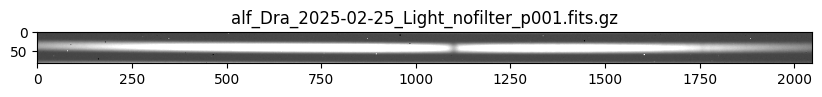

In [531]:


ha.quickplot(Light_images_correct[3][513:596,0:2048], Light_names[0])


<div class="alert alert-success">

 **Find by observation where the background is at:**

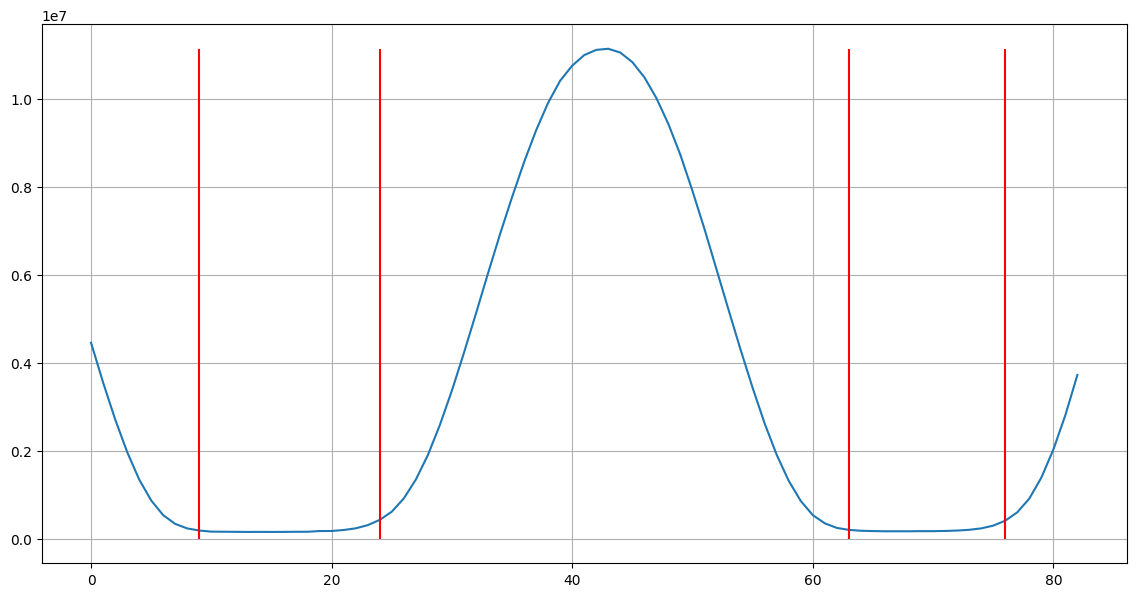

In [532]:
plt.figure(figsize=(14,7))
plt.plot(np.sum(Light_images_correct[8][513:596,0:2048],axis=1))
plt.grid()
plt.vlines(9, 0, np.max(np.sum(Light_images_correct[8][513:596,0:2048],axis=1))+2, 'red')
plt.vlines(24, 0, np.max(np.sum(Light_images_correct[8][513:596,0:2048],axis=1))+2, 'red')
plt.vlines(63, 0, np.max(np.sum(Light_images_correct[8][513:596,0:2048],axis=1))+2, 'red')
plt.vlines(76, 0, np.max(np.sum(Light_images_correct[8][513:596,0:2048],axis=1))+2, 'red')

<div class="alert alert-success">

  **Input the background range**
 
 Initial subset  = 513:596

 Background range 1 = 10:24 \
 Background range 2 = 62:79

 New subset = 513+10 : 513+79

In [533]:
513+76


589

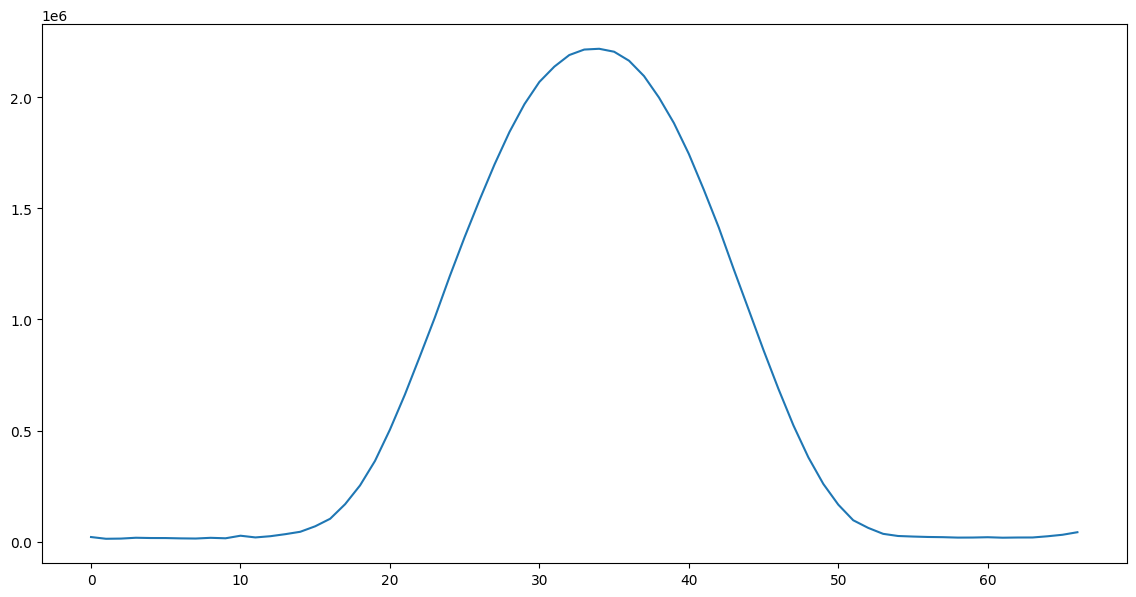

In [534]:
plt.figure(figsize=(14,7))
plt.plot(np.sum(Light_images_correct[3][522:589,0:2048],axis=1))

In [535]:
# Guetting the background
background_1= np.mean(Light_images_correct[8][513:596,0:2048][10:24])
background_2= np.mean(Light_images_correct[8][513:596,0:2048][63:79])

alf_Dra_p002_02= Light_images_correct[8][522:589,0:2048] - (background_1+ background_2)/2


In [536]:
background_combined1 = np.concatenate((background_1.flatten(), background_2.flatten()))
bakcground_mean1 = np.mean(background_combined1)
error_bg = np.std(background_combined1)/np.sqrt(len(background_combined1))

propagated_error =np.sqrt( error_bg**2 + noise**2)
noise_sqrt=np.sqrt(np.sum(propagated_error**2,axis=0))

In [537]:
noise_sqrt

array([160.50509052, 161.42637301, 161.57386878, ..., 157.9160397 ,
       157.28438494, 156.81385542])

In [538]:
propagated_error

array([[17.28199213, 17.73934249, 17.16694431, ..., 18.80798333,
        17.75902936, 18.20782326],
       [17.25903349, 17.51282422, 17.30199806, ..., 17.29797829,
        17.75365137, 17.48860535],
       [17.5737591 , 17.36255134, 17.91857037, ..., 17.27151264,
        17.2159418 , 17.30624306],
       ...,
       [17.55943712, 17.51679114, 17.01954515, ..., 22.57659445,
        18.13929649, 17.6335434 ],
       [17.46975664, 17.37887099, 17.4584021 , ..., 17.26108606,
        17.21880158, 17.75430396],
       [17.19902474, 17.13444052, 17.16527087, ..., 17.78641361,
        17.64703522, 17.76326625]])

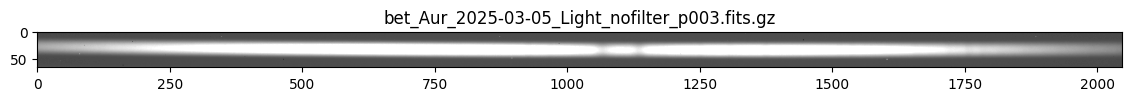

In [539]:
plt.figure(figsize=(14,7))

ha.quickplot(alf_Dra_p002_02, Light_names[8])

## H_alpha spectrum creation and normalisation

<div class="alert alert-success">

  **Collapsing the spectrum to 1D**
 
Doing sum accross x axis

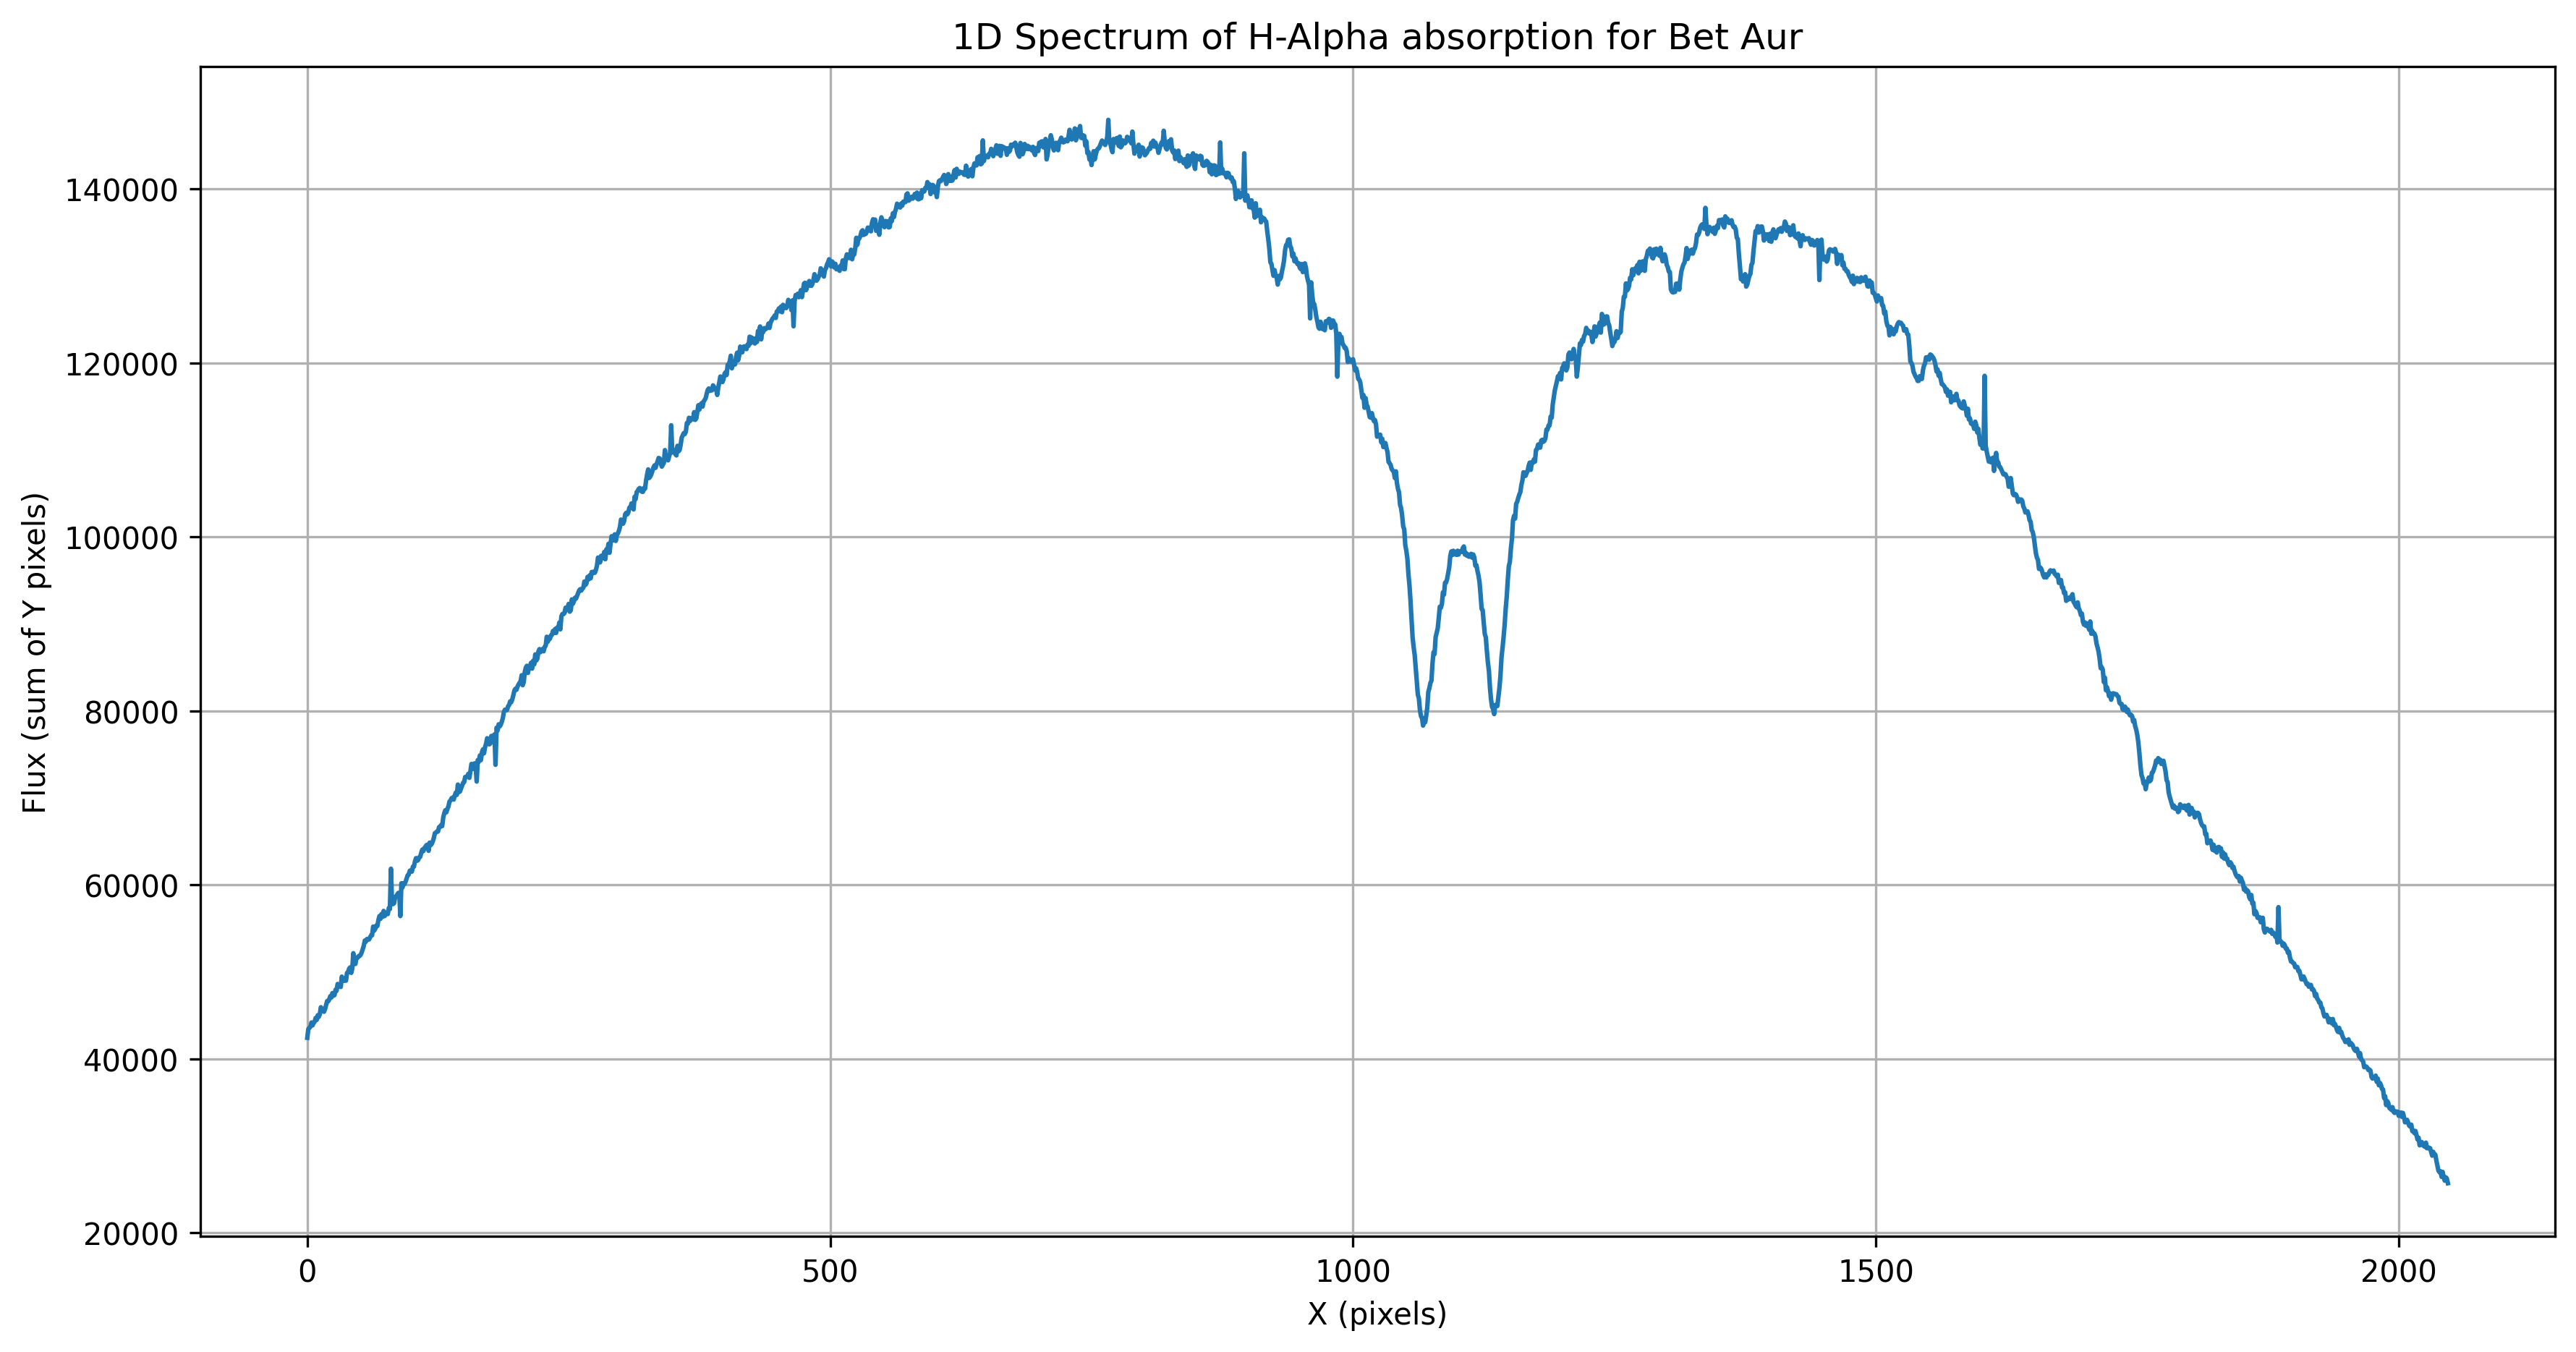

In [540]:
alf_Dra_p002_02_1D= np.sum(alf_Dra_p002_02, axis=0)

plt.figure(figsize=(14,7),dpi=300)
plt.title('1D Spectrum of H-Alpha absorption for Bet Aur')
plt.xlabel('X (pixels)')
plt.ylabel('Flux (sum of Y pixels)')
plt.grid()
plt.plot(alf_Dra_p002_02_1D)

<div class="alert alert-success">

  **Removing outliers with median filter**
 


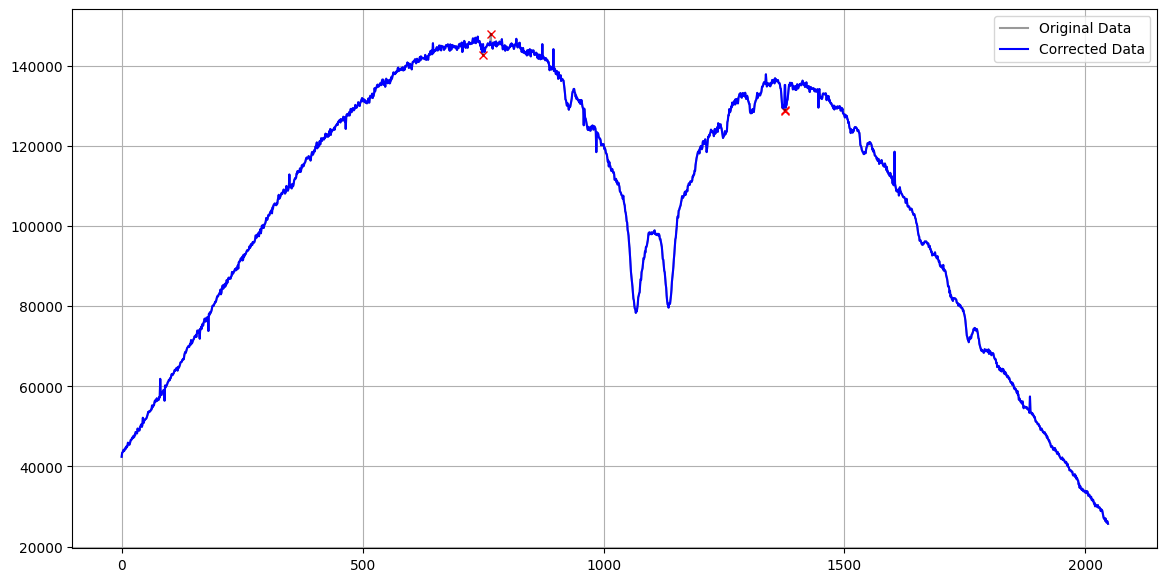

(array([42413.48782054, 43421.23782054, 43556.23782054, ...,
        26378.73782054, 26241.83782054, 25698.63782054]),
 array([160.50509052, 161.42637301, 161.57386878, ..., 157.9160397 ,
        157.28438494, 156.81385542]))

In [541]:
plt.figure(figsize=(14,7))
ha.outliers_replace_median_with_uncertainty(alf_Dra_p002_02_1D,noise_sqrt, plot=True)

In [542]:
alf_Dra_p001_02_1D_corrected, noise_corrected=ha.outliers_replace_median_with_uncertainty(alf_Dra_p002_02_1D, noise_sqrt, clip=3, windowSize=25)

[520:590,0:2048]
[520:590,0:2048]
[520:590,0:2048]

In [543]:
alf_Dra_p001_02_1D_corrected, noise_corrected=ha.MedianClipRolling(alf_Dra_p002_02_1D,noise_sqrt,clip=3, windowSize=25)

<div class="alert alert-success">

  **Normalising the spectrum**
 

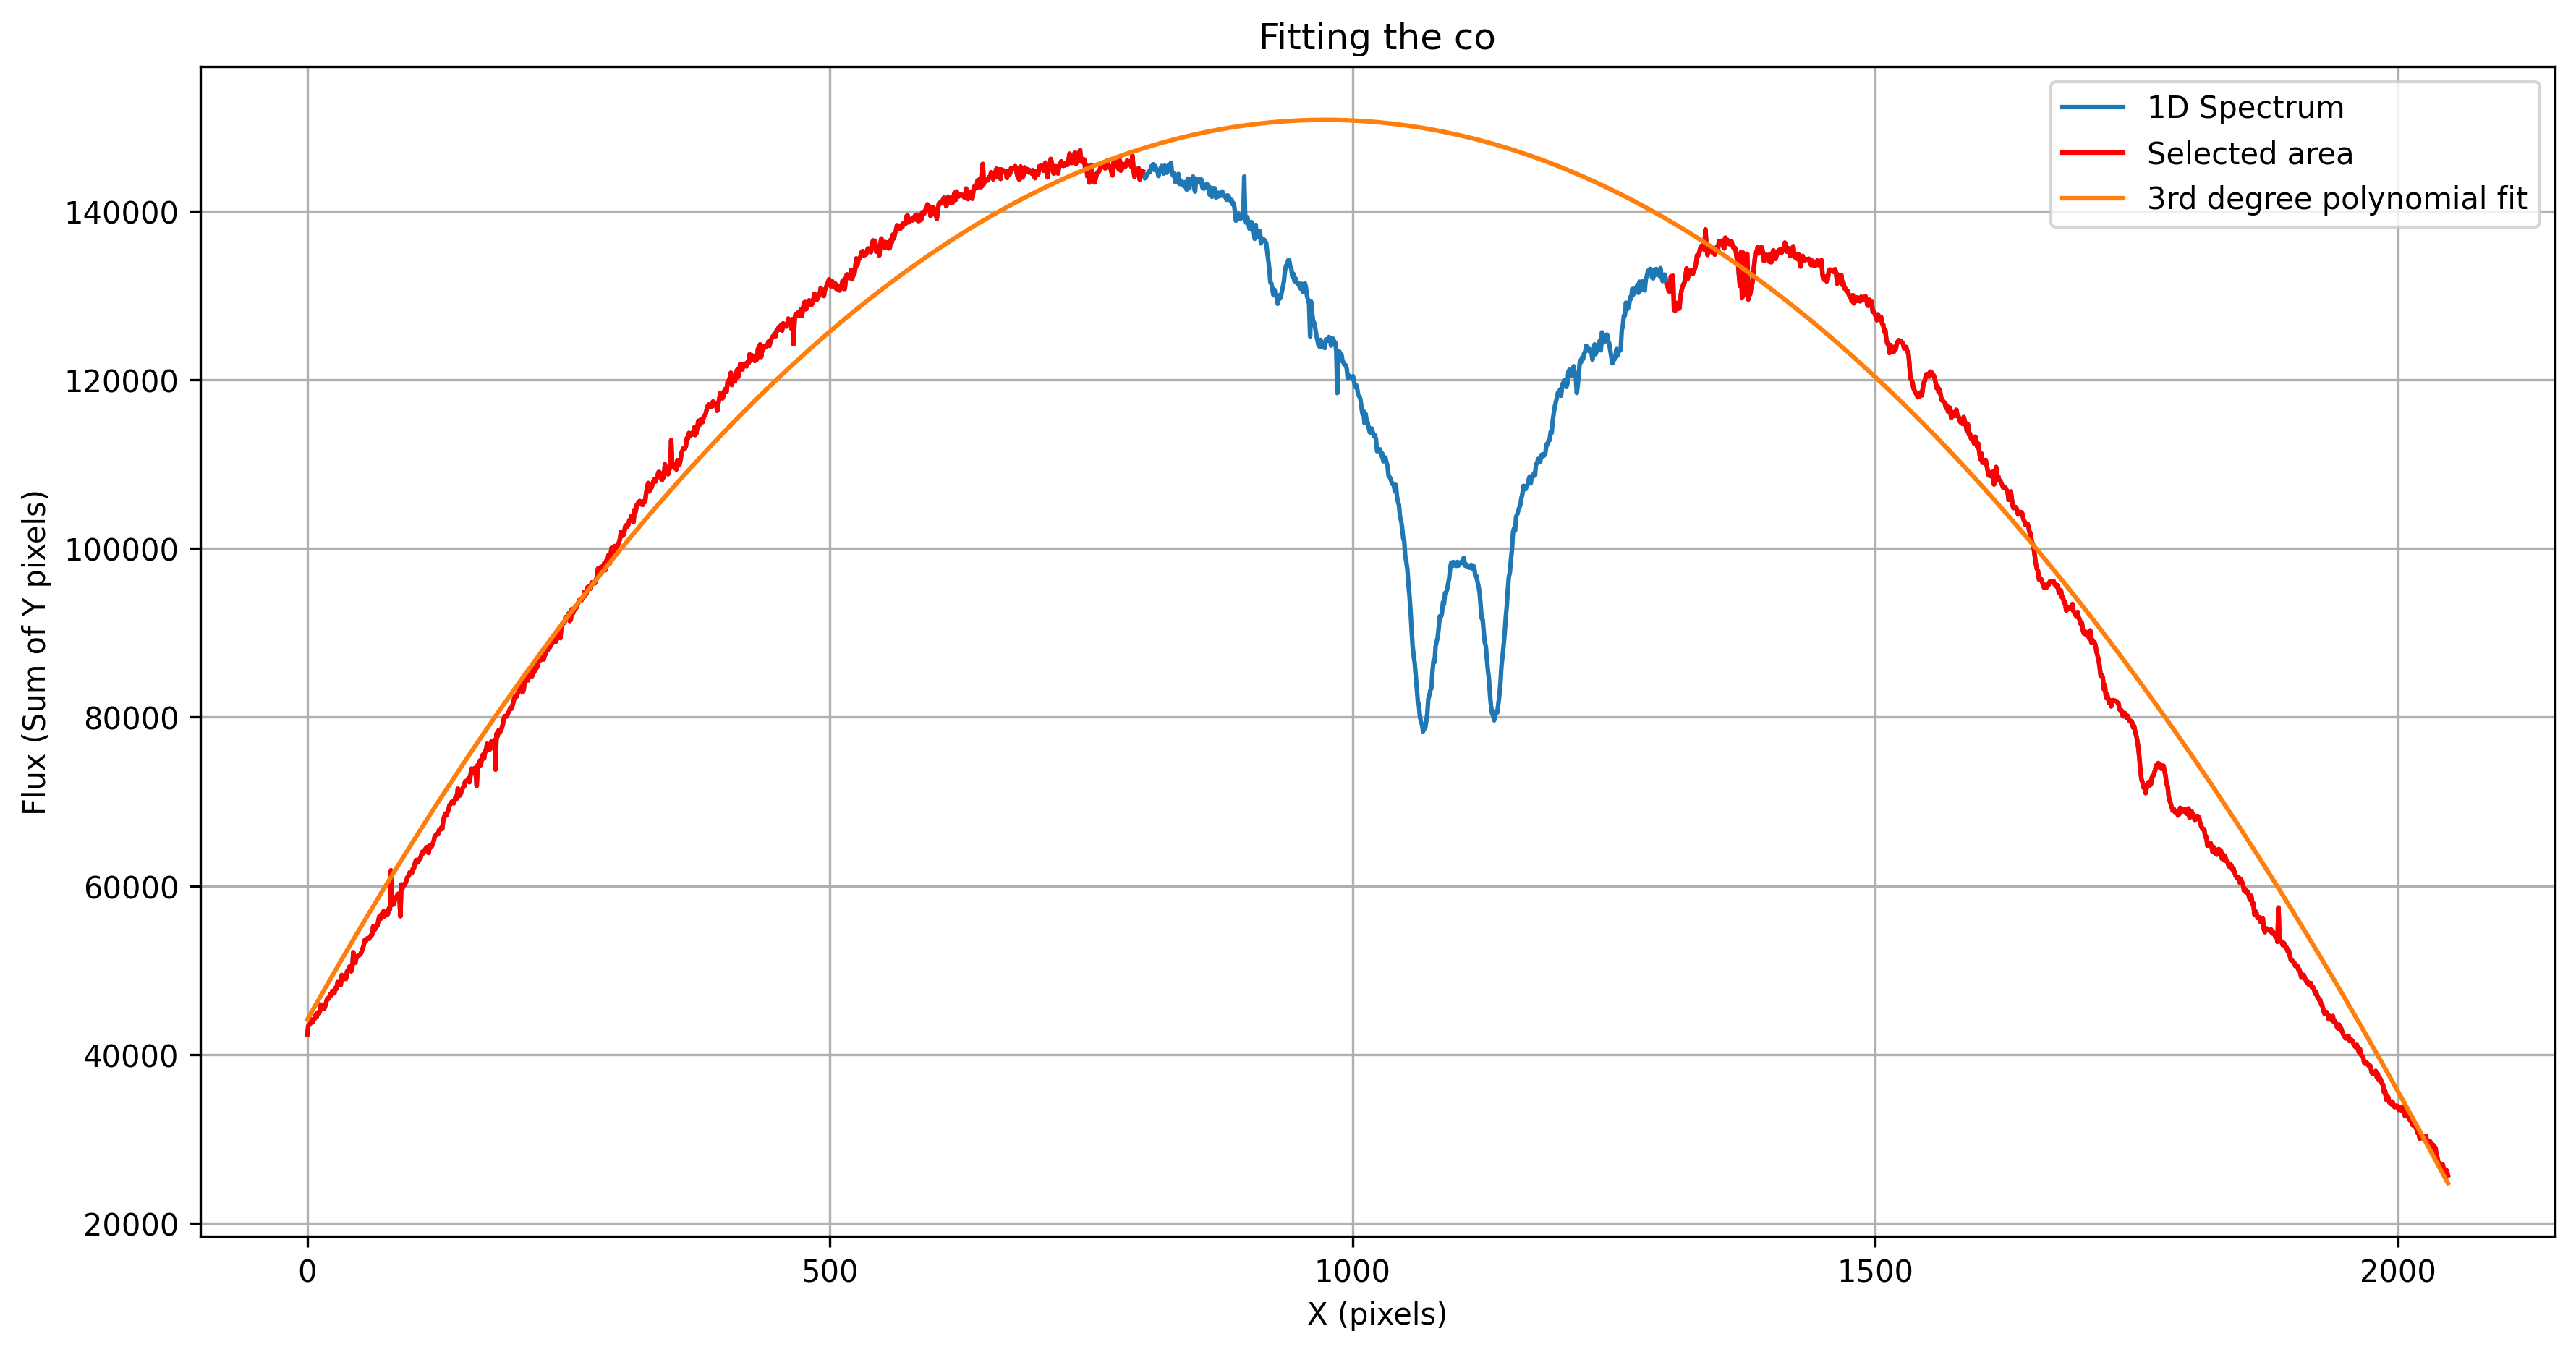

(array([0.96076671, 0.97870707, 0.97690071, ..., 1.0455942 , 1.04985406,
        1.03779531]),
 array([0.01748687, 0.01771531, 0.0175976 , ..., 0.58304476, 0.5914776 ,
        0.59079088]))

In [544]:
plt.figure(figsize=(14,7), dpi=300)
plt.title('Fitting the co')
ha.Normalise( alf_Dra_p001_02_1D_corrected,noise_corrected, 800, 1300, plot = True)


In [545]:
continium_normarlised,normalised_err= ha.Normalise( alf_Dra_p001_02_1D_corrected,noise_corrected, 700, 1300)

780, 1330

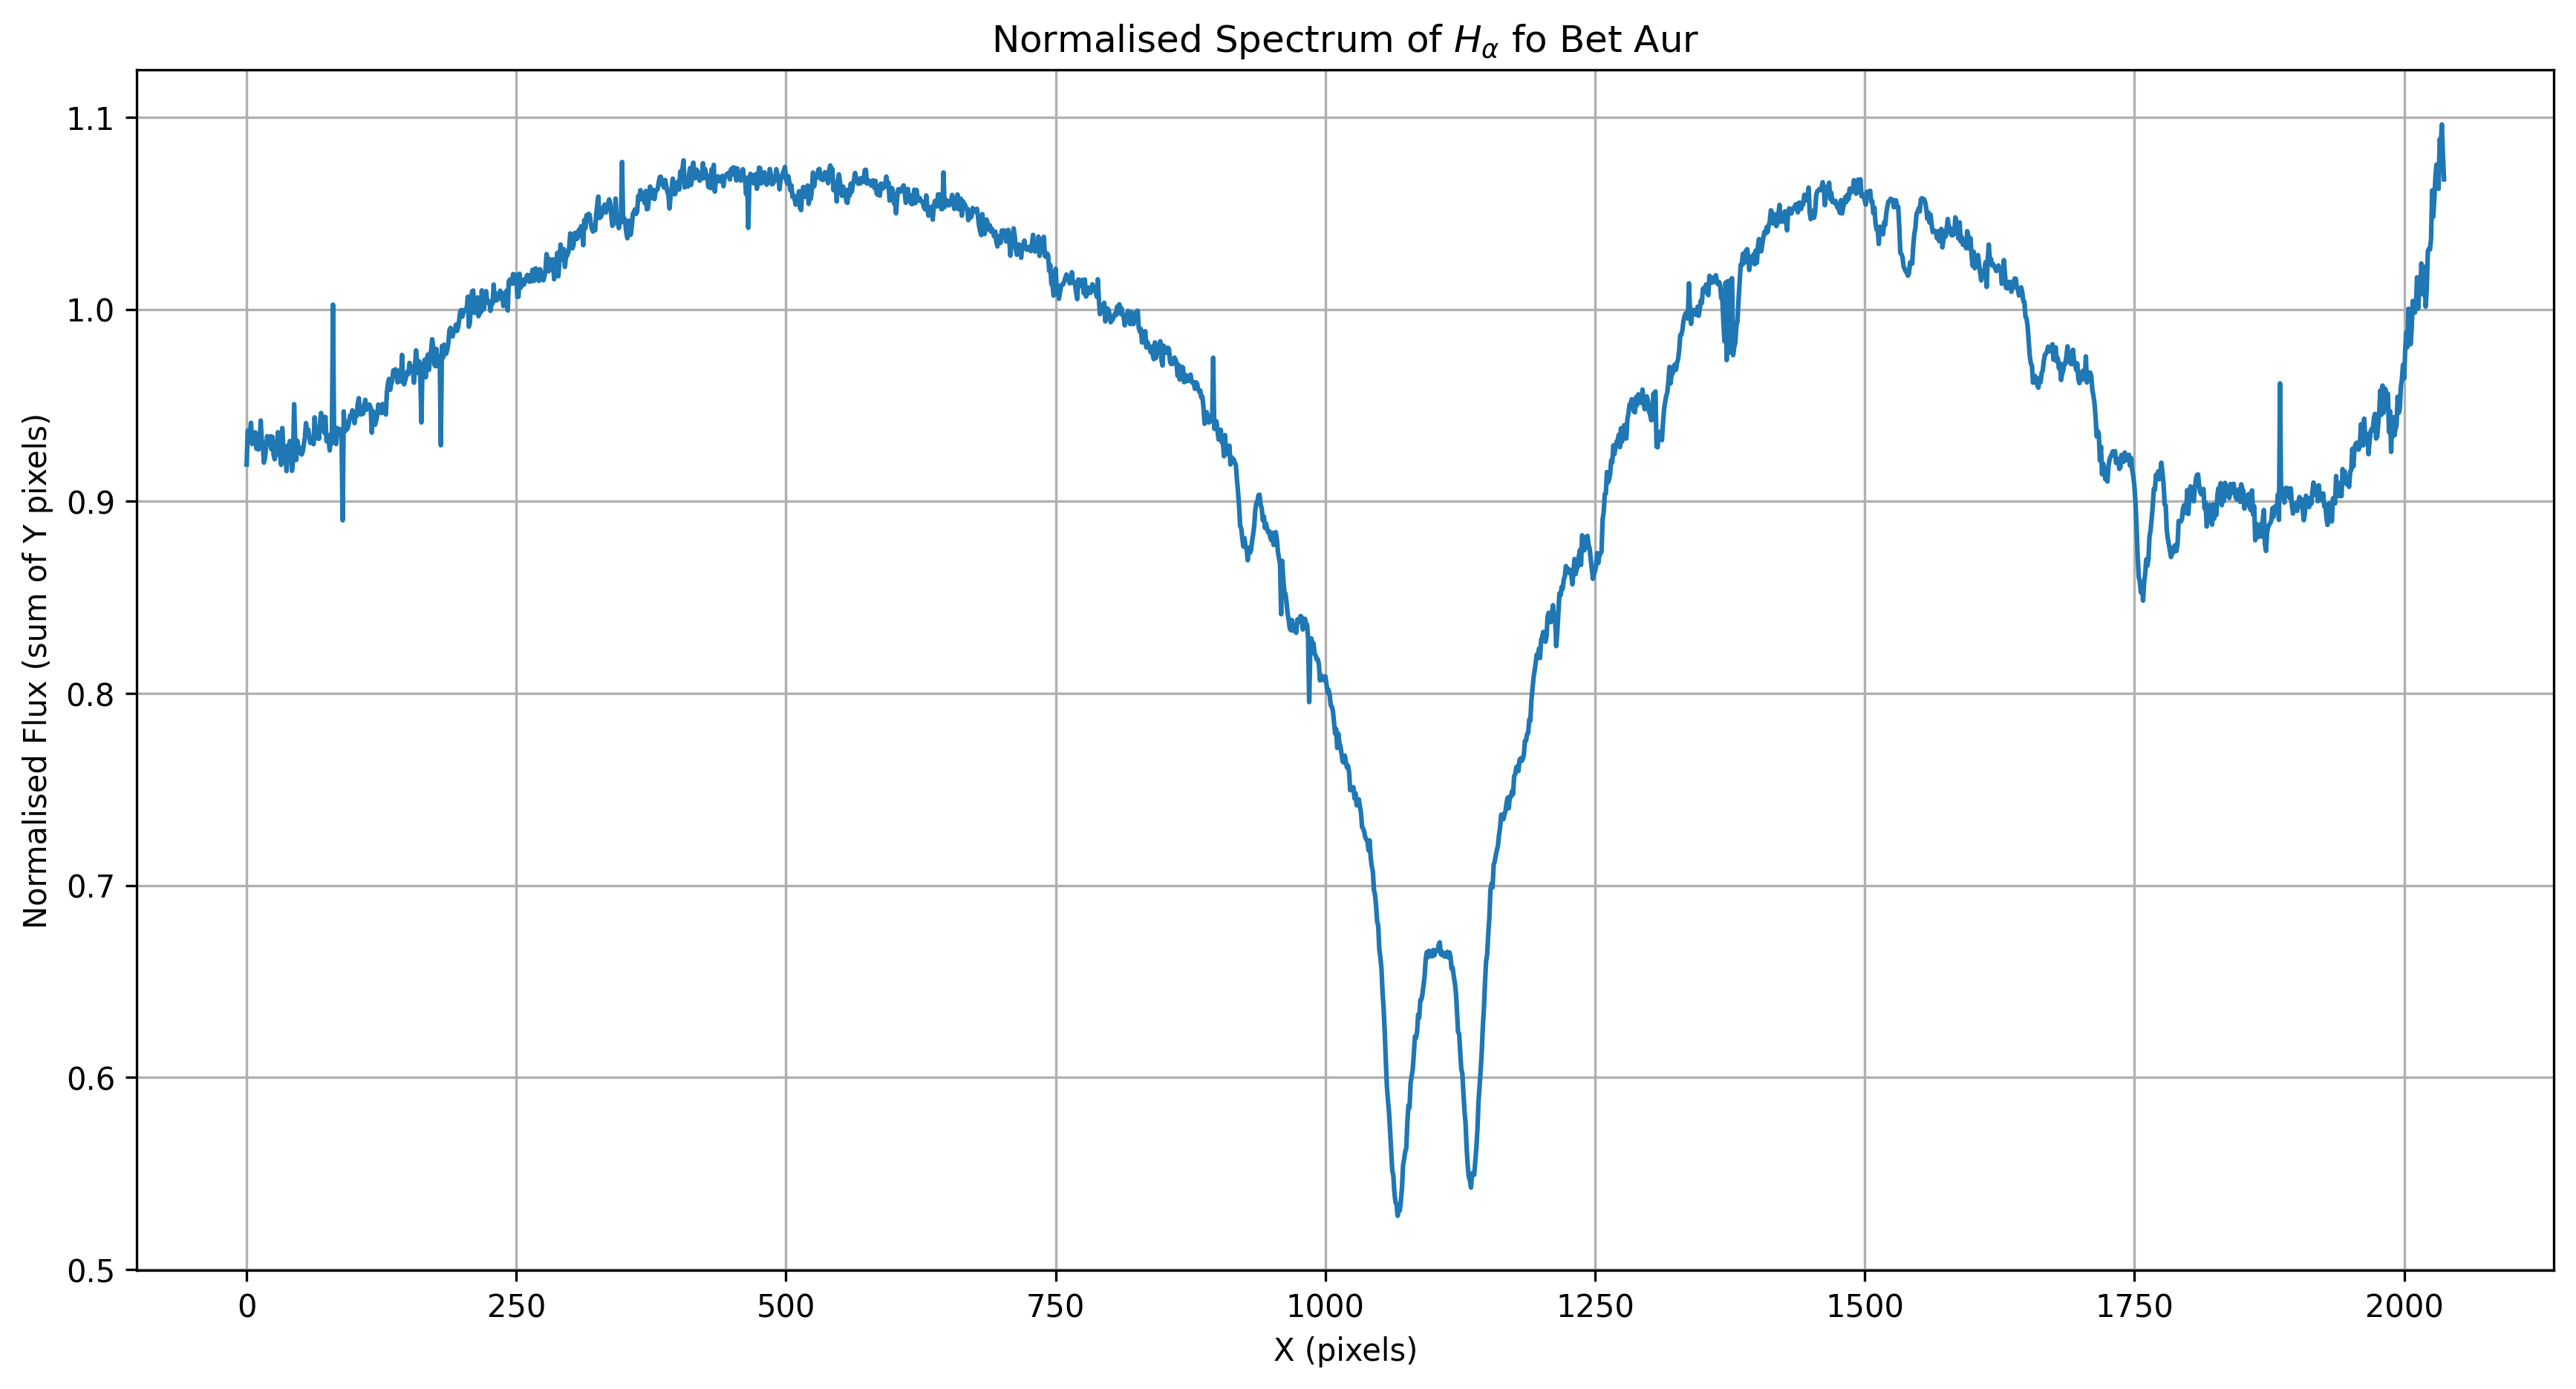

In [546]:
plt.figure(figsize=(14,7),dpi=300)
plt.title(r'Normalised Spectrum of $H_\alpha$ fo Bet Aur')
plt.grid()
plt.xlabel('X (pixels)')
plt.ylabel('Normalised Flux (sum of Y pixels)')
plt.plot(continium_normarlised[:-10])

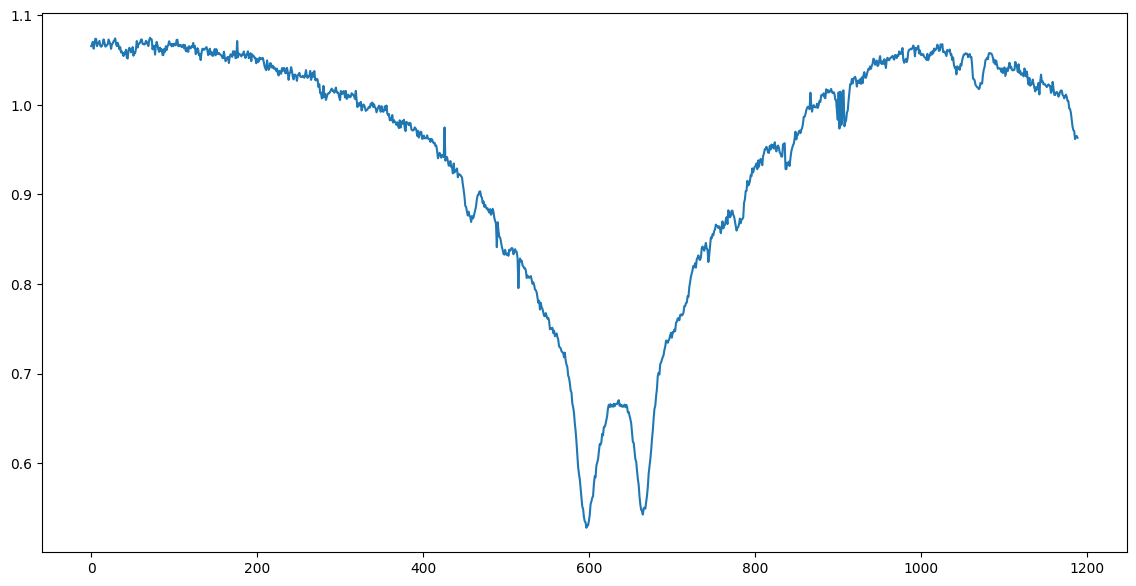

In [547]:
plt.figure(figsize=(14,7))
plt.plot(continium_normarlised[470:1660])

## Finding Amplitude and Position

<div class="alert alert-success">

  **Fitting a Lorentzian**
 
1. Full Set

2. specific Range

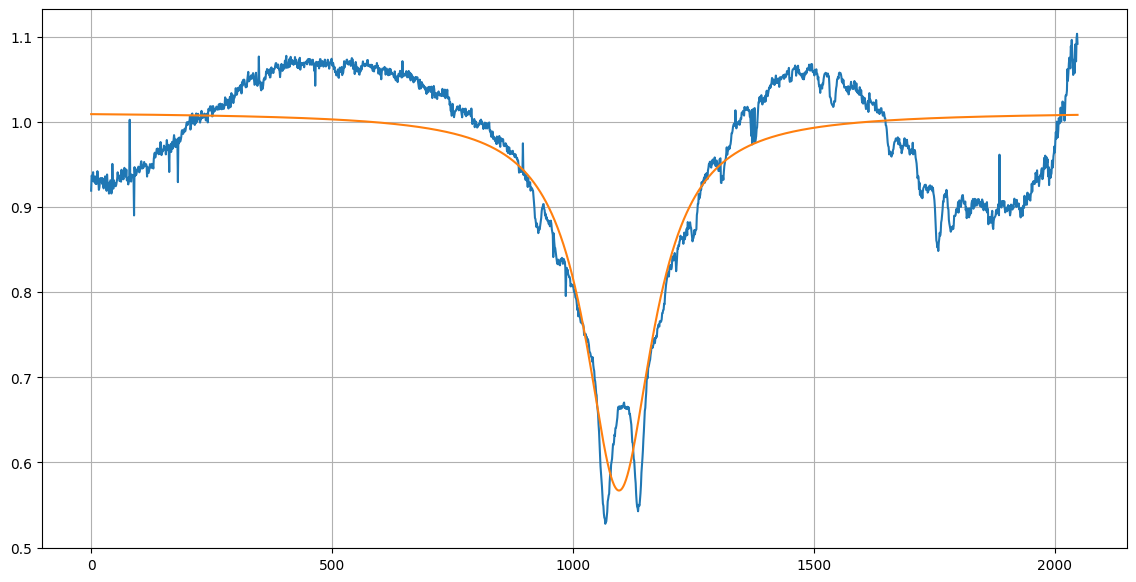

In [548]:
line_par, line_cov = optimize.curve_fit(ha.Lorentz, np.arange(0, len(continium_normarlised)), continium_normarlised, p0=[-1,-3,1000,5], sigma=normalised_err)
size = np.size(continium_normarlised)
xValues = np.linspace(0, size, size)
line_shape = ha.Lorentz(xValues,line_par[0],line_par[1],line_par[2],line_par[3])

plt.figure(figsize=(14,7))
plt.grid()
plt.plot(continium_normarlised)
plt.plot(line_shape)

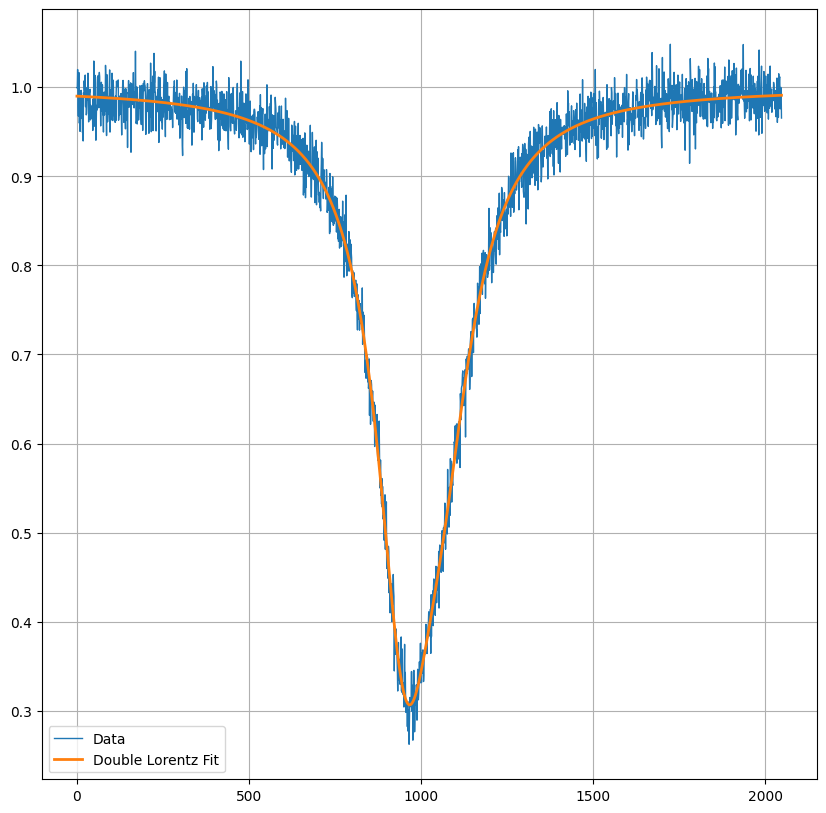

In [550]:
# Double Lorentzian function
def double_lorentz(x, amp1, center1, width1, amp2, center2, width2, offset):
    lorentz1 = amp1 / (1 + ((x - center1) / width1) ** 2)
    lorentz2 = amp2 / (1 + ((x - center2) / width2) ** 2)
    return lorentz1 + lorentz2 + offset

# Generate synthetic data
y = double_lorentz(x, -0.5, 950, 100, -0.3, 1050, 120, 1) + np.random.normal(0, 0.02, x.shape)

# Fit the Double Lorentzian
popt, _ = curve_fit(double_lorentz, x, y, p0=[-0.5, 950, 100, -0.3, 1050, 120, 1])

# Plot results
plt.plot(x, y, label="Data", linewidth=1)
plt.plot(x, double_lorentz(x, *popt), label="Double Lorentz Fit", linewidth=2)
plt.legend()
plt.grid()
plt.show()


In [552]:
x,y=np.arange(0, len(continium_normarlised[300:1600])), continium_normarlised[300:1600]

In [553]:
bounds = ([-np.inf, 900, 50, -np.inf, 900, 50, -np.inf],  # Lower bounds
          [0, 1200, 300, 0, 1200, 300, np.inf])

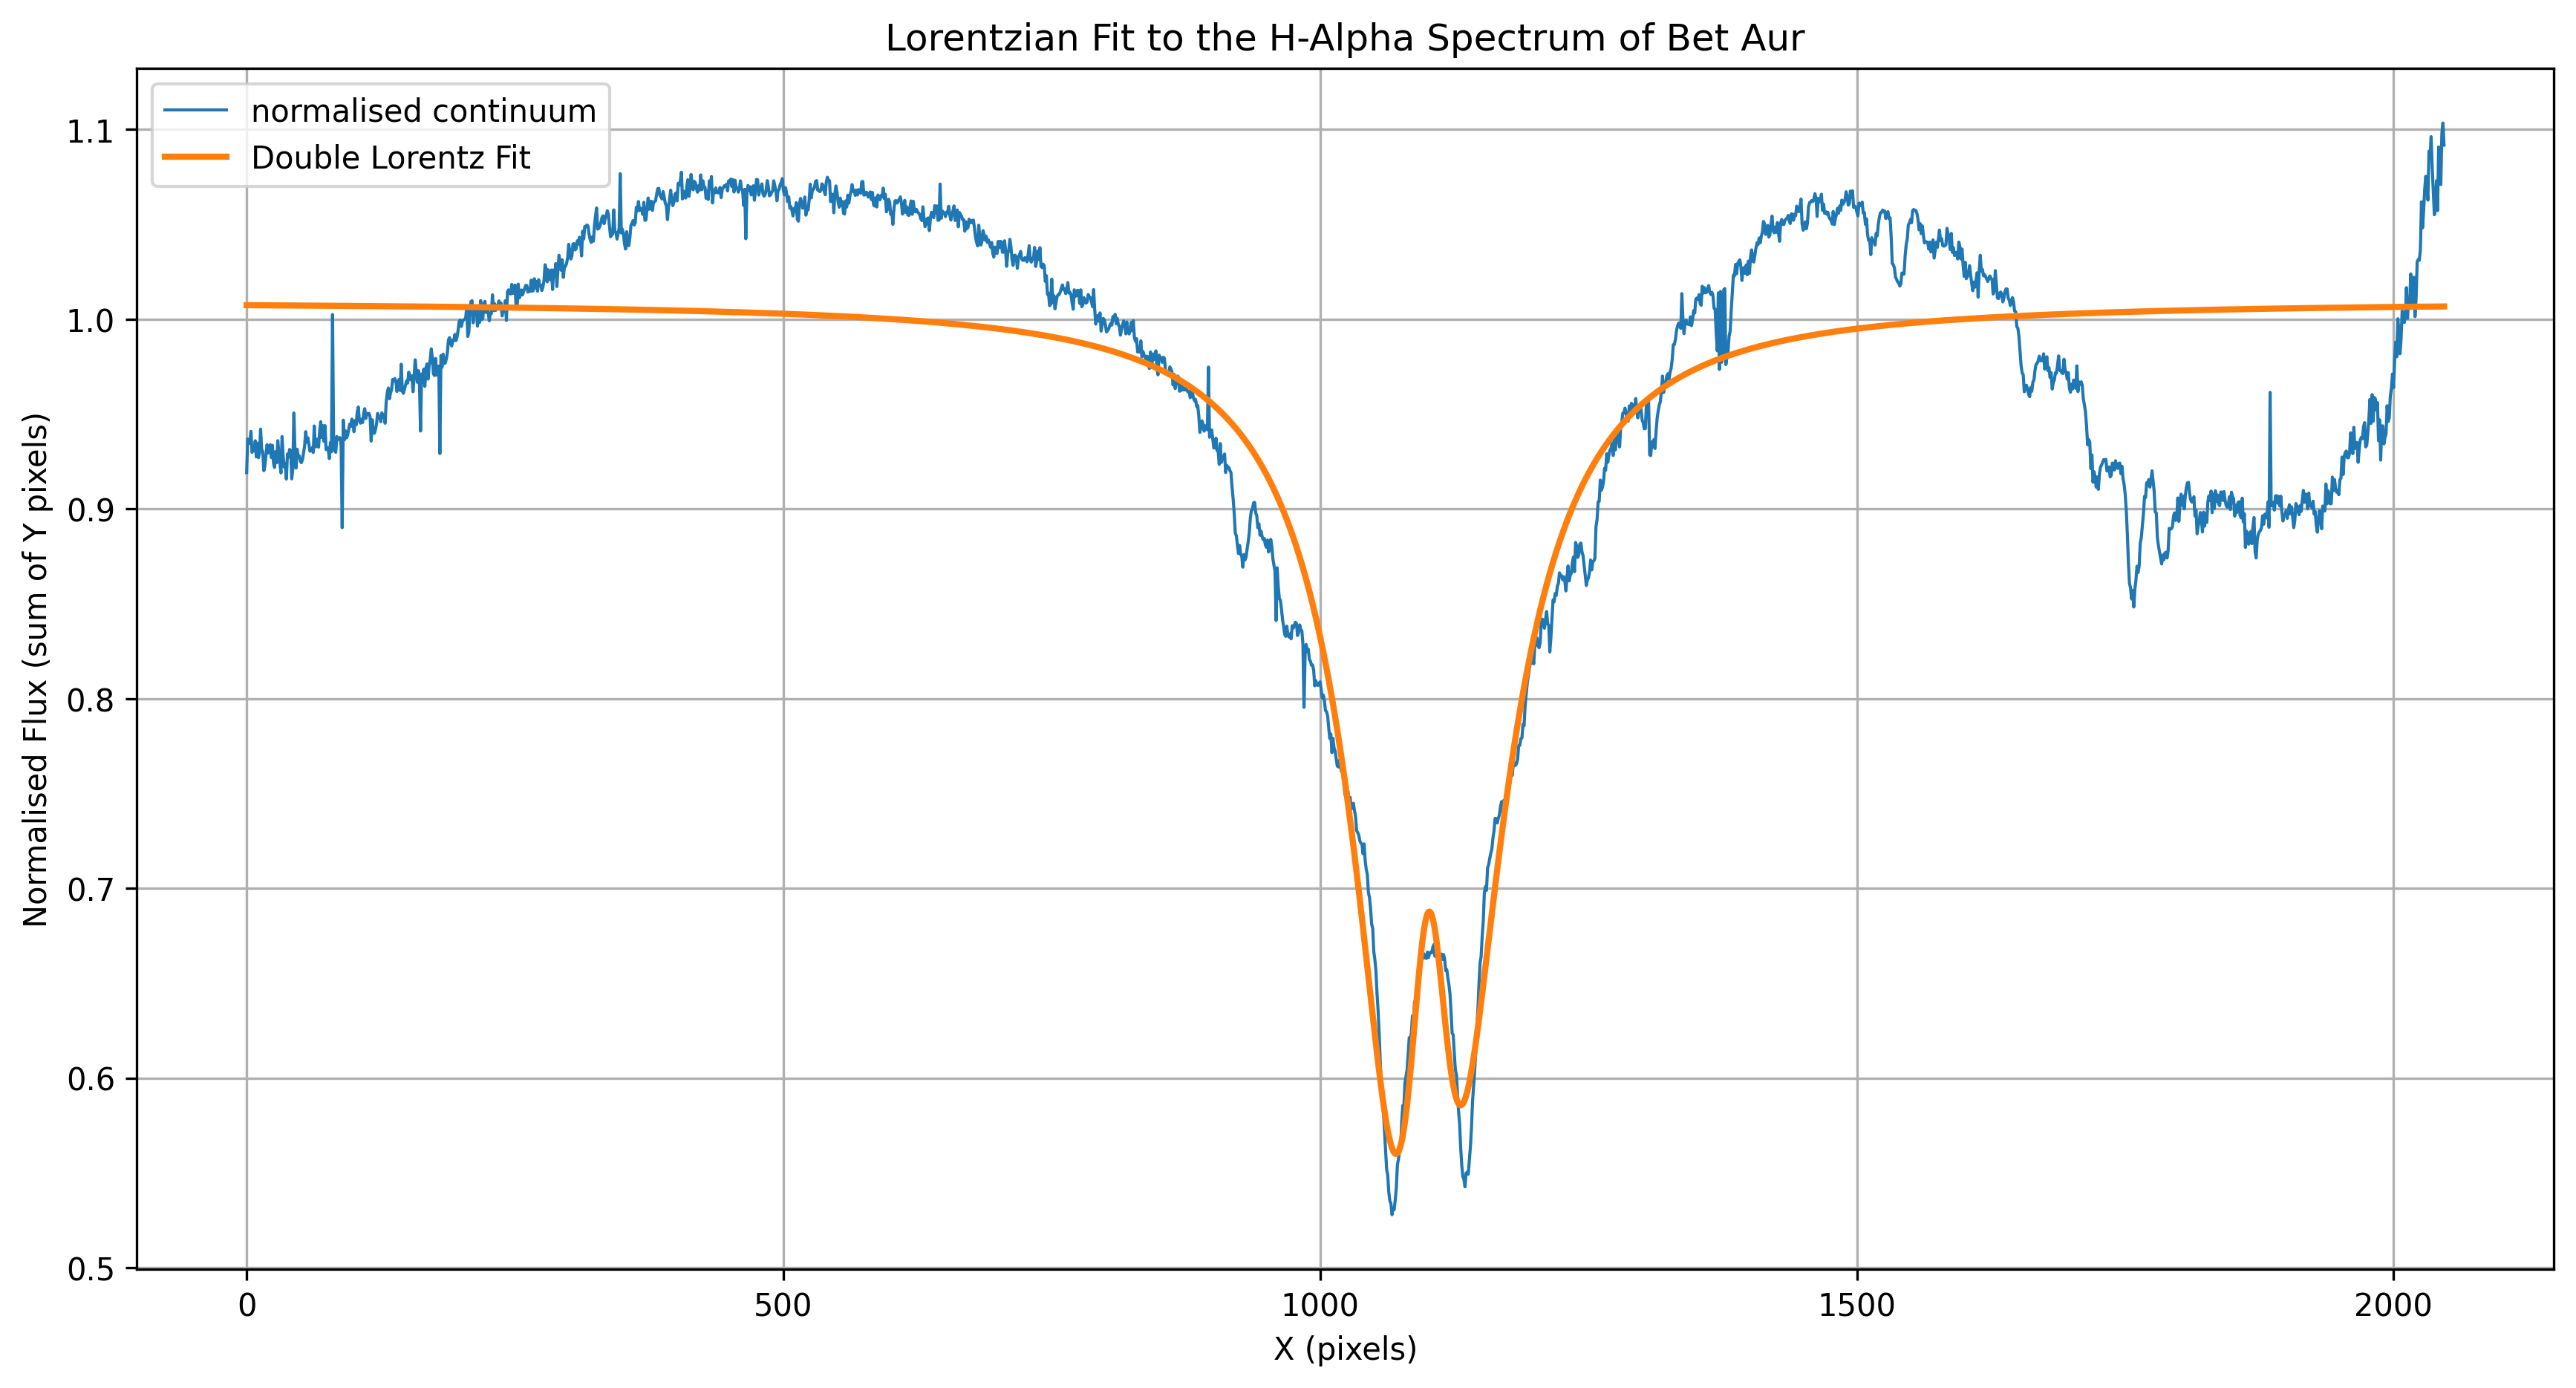

In [554]:
# Double Lorentzian function
def double_lorentz(x, amp1, center1, width1, amp2, center2, width2, offset):
    lorentz1 = amp1 / (1 + ((x - center1) / width1) ** 2)+ offset
    lorentz2 = amp2 / (1 + ((x - center2) / width2) ** 2)+ offset
    return lorentz1 + lorentz2

# Upper bounds (forcing negative amplitudes)
x,y=np.arange(0, len(continium_normarlised)), continium_normarlised


# Fit the Double Lorentzian
popt, pcov = curve_fit(double_lorentz, x, y, p0=[-0.7, 1100, 10, -0.6, 1200, 120, 10], sigma=normalised_err)

# Plot results
plt.figure(figsize=(14,7),dpi=300)

plt.plot(x, y, label="normalised continuum", linewidth=1)
plt.plot(x, double_lorentz(x, *popt), label="Double Lorentz Fit", linewidth=2)
plt.xlabel('X (pixels)')
plt.ylabel('Normalised Flux (sum of Y pixels)')
plt.title('Lorentzian Fit to the H-Alpha Spectrum of Bet Aur')
plt.legend()
plt.grid()
plt.show()


<div class="alert alert-success">

  **Best fit and parameters correction**

## Finding S/N 

In [ ]:
np.abs(amplitude/amplitude_err)

3.4874665491107737